In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics.classification import BinaryAccuracy
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)
from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)
from glob import glob
import json
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error



Seed set to 0


In [29]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

### Problem 7

In [40]:
Default = load_data("Default")
n = Default.shape[0]

model = MS(Default.columns.drop('default'), intercept=False)
X = model.fit_transform(Default).to_numpy()
Y = Default['default'].map({'Yes': 1, 'No': 0}).to_numpy()


(X_train, 
 X_test,
 Y_train,
 Y_test) = train_test_split(X,
                            Y,
                            test_size=0.25,
                            random_state=1)



input size is the number of starting parameters for the problem 

In [18]:
class DefaultModel(nn.Module):

    def __init__(self, input_size):
        super(DefaultModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10,1)
        )
    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))


In [21]:
default_model = DefaultModel(X.shape[1])
summary(default_model, 
        input_size=X_train.shape,
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DefaultModel                             [7500, 3]                 [7500]                    --
├─Flatten: 1-1                           [7500, 3]                 [7500, 3]                 --
├─Sequential: 1-2                        [7500, 3]                 [7500, 1]                 --
│    └─Linear: 2-1                       [7500, 3]                 [7500, 10]                40
│    └─ReLU: 2-2                         [7500, 10]                [7500, 10]                --
│    └─Dropout: 2-3                      [7500, 10]                [7500, 10]                --
│    └─Linear: 2-4                       [7500, 10]                [7500, 1]                 11
Total params: 51
Trainable params: 51
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.38
Input size (MB): 0.09
Forward/backward pass size (MB): 0.66
Params size (MB): 0.00
Estimated Total Size (MB): 0.75

In [25]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
default_train = TensorDataset(X_train_t, Y_train_t)

X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
default_test = TensorDataset(X_test_t, Y_test_t)

max_num_workers = rec_num_workers()

In [26]:
default_dm = SimpleDataModule(default_train,
                          default_test,
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=default_test)

In [31]:
default_module = SimpleModule.classification(default_model, num_classes=2, metrics={"accuracy": BinaryAccuracy()})
default_logger = CSVLogger('logs', name='default')

default_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=default_logger,
                        enable_progress_bar=False,
                        callbacks=[ErrorTracker()])
default_trainer.fit(default_module,
                  datamodule=default_dm)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DefaultModel     | 51     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
51        Trainable params
0         Non-trainable params
51        Total params
0.000     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=30` reached.


In [35]:
default_trainer.test(default_module, datamodule=default_dm)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9684000015258789     │
│         test_loss         │     618.0996704101562     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 618.0996704101562, 'test_accuracy': 0.9684000015258789}]

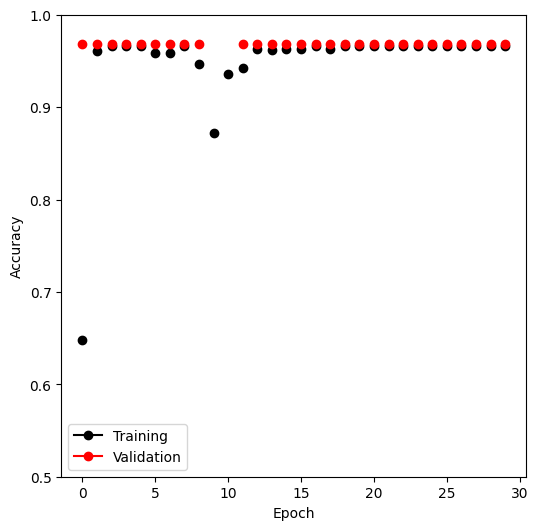

In [34]:
mnist_results = pd.read_csv(default_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(mnist_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int));

Linear Logistic Regression

In [45]:
glm = LogisticRegression(C=1e10, solver='liblinear'
             )
results = glm.fit(X_train,
             Y_train)

preds = results.predict(X_test)

print(f"Classification: { np.round(1 - mean_squared_error(Y_test, preds),4)}")

Classification: 0.9684


Better classification with straight logisitic regression than with the neural network with one hidden layer of size 10 


### Problem 9

In [35]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(
                with_mean=True,
                with_std=True).fit_transform(NYSE[cols]),
        columns=NYSE[cols].columns,
        index=NYSE.index)

In [36]:
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

In [37]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

In [6]:
M = LinearRegression()
M.fit(X[train], Y[train])
M.score(X[~train], Y[~train])

0.41289129385625223

In [8]:

NYSE['month'] = pd.to_datetime(NYSE.index).month_name()

X_month = pd.concat([
    X,
    pd.get_dummies(NYSE['month'], prefix='month')
], axis=1).dropna()

In [9]:
M = LinearRegression()
M.fit(X_month[train], Y[train])
M.score(X_month[~train], Y[~train])

0.4167123048568927

Not much better using the traditional linear AR with the month data included, the days was better



### Problem 10

In [13]:
ordered_cols = []
for lag in range(5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col, lag))
X = X.reindex(columns=ordered_cols)
X.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [10]:
X_rnn = X.to_numpy().reshape((-1,5,3))
X_rnn.shape

(6046, 5, 3)

In [16]:
class NYSEModel(nn.Module):
    def __init__(self, input_dim):
        super(NYSEModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        x = self.flatten(x)
        return self.linear(x).squeeze(-1)
nyse_model = NYSEModel(X_month.shape[1])

In [17]:
datasets = []
for mask in [train, ~train]:
    X_month_t = torch.tensor(
                   np.asarray(X_month[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_month_t, Y_t))
day_train, day_test = datasets

In [18]:
summary(nyse_model,
        input_data=X_month_t,
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 27]                [1770]                    --
├─Flatten: 1-1                           [1770, 27]                [1770, 27]                --
├─Linear: 1-2                            [1770, 27]                [1770, 1]                 28
Total params: 28
Trainable params: 28
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.05
Input size (MB): 0.19
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.21

In [22]:
nyse_dm = SimpleDataModule(day_train,
                          day_test,
                          num_workers=5,
                          validation=day_test,
                          batch_size=64)


In [23]:
for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break


torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


In [24]:
nyse_optimizer = RMSprop(nyse_model.parameters(),
                         lr=0.001)
nyse_module = SimpleModule.regression(nyse_model,
                                      optimizer=nyse_optimizer,
                                      metrics={'r2':R2Score()})


In [25]:
nyse_trainer = Trainer(deterministic=True,
                       max_epochs=200,
                       enable_progress_bar=False,
                       callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module,
                 datamodule=nyse_dm)
nyse_trainer.test(nyse_module,
                  datamodule=nyse_dm)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\campz\anaconda3\envs\ISLP\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NYSEModel | 28     | train
1 | loss  | MSELoss   | 0      | train
-------------------------------

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6153295040130615     │
│          test_r2          │    0.41602230072021484    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6153295040130615, 'test_r2': 0.41602230072021484}]

### Problem 12

In [27]:
%reset

In [2]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(
                     with_mean=True,
                     with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)


In [3]:
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()


In [4]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns


Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

In [5]:
X_day = pd.concat([X, 
                  pd.get_dummies(NYSE['day_of_week'])],
                  axis=1).dropna()

In [6]:
ordered_cols = []
for lag in range(5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col, lag))
X = X_day.reindex(columns=ordered_cols)
X.columns


Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [7]:
X_rnn = X.to_numpy().reshape((-1,5,3))
X_rnn.shape

(6046, 5, 3)

In [8]:
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(
                   np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, Y_t))
day_train, day_test = datasets

In [9]:
nyse_dm = SimpleDataModule(day_train,
                           day_test,
                           num_workers=4,
                           validation=day_test,
                           batch_size=64)


In [17]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(20,
                          12,
                          batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        val, h_n = self.rnn(x)
        if val.ndim == 3:
            val_last = val[:, -1, :]   # multiple timesteps
        else:
            val_last = val
        val_out = self.dense(self.dropout(val_last))
        return torch.flatten(val_out)
nyse_model = NYSEModel()

In [18]:
nyse_optimizer = RMSprop(nyse_model.parameters(),
                         lr=0.001)
nyse_module = SimpleModule.regression(nyse_model,
                                      optimizer=nyse_optimizer,
                                      metrics={'r2':R2Score()})


In [19]:
nyse_trainer = Trainer(deterministic=True,
                       max_epochs=200,
                       enable_progress_bar=False,
                       callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module,
                 datamodule=nyse_dm)
nyse_trainer.test(nyse_module,
                  datamodule=nyse_dm)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NYSEModel | 421    | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
421       Trainable params
0         Non-trainable params
421       Total params
0.002     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=200` reached.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5765397548675537     │
│          test_r2          │    0.4528356194496155     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5765397548675537, 'test_r2': 0.4528356194496155}]